In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [8]:
from tensorflow.keras import layers

class Linear(layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(input_dim, units), dtype='float32'), trainable=True)
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(initial_value=b_init(shape=(units,), dtype="float32"),trainable=True)
    
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

x = tf.ones((2,2))
linear_layer = Linear(4,2)
y = linear_layer(x)
print(y)


tf.Tensor(
[[ 0.00355105  0.16650686 -0.14457193 -0.08985979]
 [ 0.00355105  0.16650686 -0.14457193 -0.08985979]], shape=(2, 4), dtype=float32)


In [9]:
assert linear_layer.weights == [linear_layer.w, linear_layer.b]

In [11]:
class Linear(layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)
    
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

x = tf.ones((2,2))
linear_layer = Linear(4,2)
y = linear_layer(x)
print(y)

tf.Tensor(
[[ 0.03144151 -0.01216179  0.01912926  0.06848297]
 [ 0.03144151 -0.01216179  0.01912926  0.06848297]], shape=(2, 4), dtype=float32)


In [14]:
class ComputeSum(layers.Layer):
    def __init__(self, input_dim):
        super(ComputeSum, self).__init__()
        self.total = tf.Variable(initial_value=tf.zeros(input_dim,), trainable=False)
    def call(self, inputs):
        self.total.assign_add(tf.reduce_sum(inputs, axis=0))
        return self.total
x = tf.ones((2,2))
my_sum = ComputeSum(2)
y = my_sum(x)
print(y.numpy())
y = my_sum(x)
y = my_sum(x)
print(y.numpy())

[2. 2.]
[6. 6.]


In [15]:
print("weights:", len(my_sum.weights))
print("non-trainable weights:", len(my_sum.non_trainable_weights))
print("trainable weights:",my_sum.trainable_weights)

weights: 1
non-trainable weights: 1
trainable weights: []


In [21]:
class Linear(layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                    initializer="random_normal",
                                    trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer="random_normal", trainable=True)
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [23]:
linear_layer = Linear(32)
y = linear_layer(x)
y

<tf.Tensor: shape=(2, 32), dtype=float32, numpy=
array([[-0.0331331 , -0.01813734, -0.06477976,  0.01119325, -0.04307769,
         0.09344503,  0.0338332 , -0.1452323 , -0.019083  , -0.0283331 ,
        -0.10489541,  0.03940399, -0.04188932, -0.01136085,  0.02615064,
         0.08063985, -0.0386435 , -0.0694808 ,  0.13542259,  0.12774767,
        -0.15723357, -0.07374229,  0.04974367, -0.10200937,  0.12304308,
        -0.05919454,  0.00974186, -0.06059979, -0.05236447, -0.16237456,
        -0.06443098, -0.12150645],
       [-0.0331331 , -0.01813734, -0.06477976,  0.01119325, -0.04307769,
         0.09344503,  0.0338332 , -0.1452323 , -0.019083  , -0.0283331 ,
        -0.10489541,  0.03940399, -0.04188932, -0.01136085,  0.02615064,
         0.08063985, -0.0386435 , -0.0694808 ,  0.13542259,  0.12774767,
        -0.15723357, -0.07374229,  0.04974367, -0.10200937,  0.12304308,
        -0.05919454,  0.00974186, -0.06059979, -0.05236447, -0.16237456,
        -0.06443098, -0.12150645]], dtyp

In [31]:
class MLPBlock(layers.Layer):
    def __init__(self):
        super(MLPBlock, self).__init__()
        self.linear_1 = Linear(32)
        self.linear_2 = Linear(32)
        self.linear_3 = Linear(1)
    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        return self.linear_3(x)
mlp = MLPBlock()
y = mlp(tf.ones(shape=(3, 64)))
print("weights:", len(mlp.weights))
print("trainable weights:", len(mlp.trainable_weights))

weights: 6
trainable weights: 6


In [41]:
class ActivityRegularizationLayer(layers.Layer):
    def __init__(self, rate=1e-2):
        super(ActivityRegularizationLayer, self).__init__()
        self.rate = rate
    def call(self, inputs):
        self.add_loss(self.rate * tf.reduce_sum(inputs))
        return inputs

In [42]:
class OuterLayer(layers.Layer):
    def __init__(self):
        super(OuterLayer, self).__init__()
        self.activity_reg = ActivityRegularizationLayer(1e-2)

    def call(self, inputs):
        return self.activity_reg(inputs)

In [46]:
layer = OuterLayer()
assert len(layer.losses) == 0
_ = layer(tf.zeros(1,1))
assert len(layer.losses) == 1
_ = layer(tf.zeros(1,1))
assert len(layer.losses) == 1

In [51]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Encoder(layers.Layer):
    def __init__(self,
                latent_dim=32,
                intermediate_dim=64,
                name='encoder',
                **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

class Decoder(layers.Layer):
    def __init__(self,
                original_dim,
                intermediate_dim=64,
                name="decoder",
                **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
        self.dense_output = layers.Dense(original_dim, activation='sigmoid')
    
    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)

class VariationalAutoEncoder(tf.keras.Model):
    def __init__(self,
                original_dim,
                intermediate_dim=64,
                latent_dim=32,
                name='autoencoder',
                **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean( z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

In [54]:
original_dim = 784
vae = VariationalAutoEncoder(original_dim, 64, 32)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

loss_metric = tf.keras.metrics.Mean()

(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

epochs = 3

for epoch in range(epochs):
    print("Start of epoch %d" % (epoch,))

    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(x_batch_train)
            loss = mse_loss_fn(x_batch_train, reconstructed)
            loss += sum(vae.losses)
        
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        loss_metric(loss)

        if step % 100 == 0:
            print('step %s: mean loss = %s' % (step, loss_metric.result()))

Start of epoch 0
step 0: mean loss = tf.Tensor(0.34648913, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(0.12550786, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(0.0991295, shape=(), dtype=float32)
step 300: mean loss = tf.Tensor(0.08919467, shape=(), dtype=float32)
step 400: mean loss = tf.Tensor(0.08424322, shape=(), dtype=float32)
step 500: mean loss = tf.Tensor(0.08090792, shape=(), dtype=float32)
step 600: mean loss = tf.Tensor(0.07873942, shape=(), dtype=float32)
step 700: mean loss = tf.Tensor(0.07716029, shape=(), dtype=float32)
step 800: mean loss = tf.Tensor(0.07596049, shape=(), dtype=float32)
step 900: mean loss = tf.Tensor(0.07496917, shape=(), dtype=float32)
Start of epoch 1
step 0: mean loss = tf.Tensor(0.07466925, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(0.07402042, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(0.073520966, shape=(), dtype=float32)
step 300: mean loss = tf.Tensor(0.07303121, shape=(), dtype=float32)
step

In [91]:
vae2 = VariationalAutoEncoder(784, 64, 32)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae2.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae2.fit(x_train, x_train, epochs=20, batch_size=64)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 49us/sample - loss: 0.0748
Epoch 2/20
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0676
Epoch 3/20
60000/60000 [==============================] - 2s 42us/sample - loss: 0.0676
Epoch 4/20
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0675
Epoch 5/20
60000/60000 [==============================] - 3s 42us/sample - loss: 0.0675
Epoch 6/20
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0675
Epoch 7/20
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0674
Epoch 8/20
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0674
Epoch 9/20
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0674
Epoch 10/20
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0674
Epoch 11/20
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0674
Epoch 1

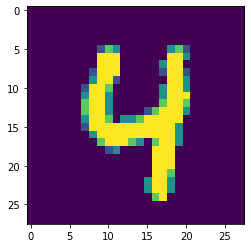

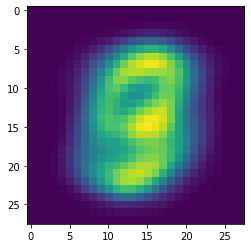

In [102]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

number = 1000
ele = train_dataset.take(number)
ele2 = next(iter(ele)).numpy()[0].reshape(28,28)
reconstructs = vae2(next(iter(ele)))
reconstructed_example = reconstructs.numpy()[0].reshape(28,28)
imshow(ele2.reshape(28,28))
plt.show()
imshow(reconstructed_example)
plt.show()

